In [111]:
!pip install kmodes
!pip install wordcloud
# !pip install plotly-express
# !pip install geopandas

In [112]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import re
import altair as alt
from vega_datasets import data as vega_data
from wordcloud import WordCloud, STOPWORDS
# import geopandas as gpd

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from plotnine import *
import plotnine
from tqdm import tqdm
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
random_state = 1234

%matplotlib inline

## Regroup subaward_description column

Using text analysis tfidf

In [113]:
df = pd.read_csv("Dataset_Contract_Sub-Awards.csv")
vec_names = df['subaward_description']
df['subaward_description'] = df['subaward_description'].str.rstrip(".")
df['index'] = df.reset_index().index

### Data cleaning

In [114]:
# remove ending dots
vec_names = vec_names.str.rstrip(".")

### cosine similarity
The `subaward_description` are strings after parsing. So before computing the similarity, we just need tf-idf to measure the term weights.


In [115]:
## parsing, by special charactors
terms = [re.split("[',:/ .&()-]" ,nm) for nm in vec_names]

## remove "", "Other" or any terms with length = 1
terms = [[value for value in item if (value != ('' or 'Other' or 'Others')) and (len(value)>2) ] for item in terms] 
## freqency
freq = collections.Counter(sum(terms, []))
## dict with terms and index
# dic = dict(zip(df['index'],[' '.join(sorted(set(i), key=i.index)) for i in terms]))
df['subaward_description_simple'] = [' '.join(sorted(set(i), key=i.index)) for i in terms]
df['subaward_description_simple']

0      Detonator Initiator Fuselage Gen Structural As...
1      Detonator Initiator Fuselage Gen Structural As...
2                                    Cost Plus Fixed Fee
3                                    Cost Plus Fixed Fee
4                                    Cost Plus Fixed Fee
                             ...                        
343                                     Firm Fixed Price
344                                    Lithium Batteries
345                                     Firm Fixed Price
346                                     Firm Fixed Price
347                                     Firm Fixed Price
Name: subaward_description_simple, Length: 348, dtype: object

In [116]:
## generate vectors
vecs = []

seen = set()

for (term, nm) in zip(terms, vec_names):
    if nm in seen: continue ## each unique name only process once
    seen.add(nm)
    vec = [1/freq[wd] for wd in term]
    # normalize
    ln = sum(x**2 for x in vec)**(1/2)
    vec_std = [x/ln for x in vec]
    vecs.append({k:e for k,e in zip(term, vec_std)})

In [117]:
def simliarity(v1,v2):
    res = 0
    for k in v1:
        if k in v2:
            res += v1[k]*v2[k]
    return min(1,res)

In [118]:
## distance, distance = 1-simliarity, smaller distance --> more similar
n = len(vecs)
mtx = [[0]*n for _ in range(n)]

for i in range(n):
    for j in range(i,n):
        mtx[i][j] = mtx[j][i] = 1-simliarity(vecs[i], vecs[j])

In [119]:
# distance = [1-simliarity(vecs[i], vecs[j]) for j in range(n) for i in range(j)]
# Z = hierarchy.linkage(distance, 'average')
# plt.figure()

# dn1 = hierarchy.dendrogram(Z, truncate_mode='level', p = 4,
#                            orientation='top', color_threshold = 0.995)
# ## need to change color below threshold
# ## need to remove x labels
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [120]:
# distance = [simliarity(vecs[i], vecs[j]) for j in range(n) for i in range(j)]
# Z = hierarchy.linkage(distance, 'average')
# plt.figure()
# # dn = hierarchy.dendrogram(Z)

# hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
# fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
#                            orientation='top', color_threshold = 0.01)
# hierarchy.set_link_color_palette(None)  # reset to default after use
# plt.show()

Get groups of each record

In [121]:
cluster = AgglomerativeClustering(n_clusters=8, 
                                  affinity='precomputed', linkage='average')

# model = AgglomerativeClustering(affinity='precomputed',
#                                 compute_full_tree = True,
#                                 linkage='average', n_clusters = None,
#                                 distance_threshold = 0.997)

labels = cluster.fit_predict(mtx)
labels

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 6, 1, 1, 5, 1, 1, 1, 4, 1, 7, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1])

In [122]:
# import numpy as np

# from matplotlib import pyplot as plt
# from scipy.cluster.hierarchy import dendrogram
# from sklearn.datasets import load_iris
# from sklearn.cluster import AgglomerativeClustering


# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack(
#         [model.children_, model.distances_, counts]
#     ).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)

# # setting distance_threshold=0 ensures we compute the full tree.
# model = AgglomerativeClustering(affinity='precomputed',
#                                 compute_full_tree = True,
#                                 linkage='average', n_clusters = None,
#                                 distance_threshold = 0.995)

# model = model.fit(mtx)
# plt.title("Hierarchical Clustering Dendrogram")
# # plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode="lastp", p = 3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [123]:
elements_count = collections.Counter(labels)
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

1: 59
0: 7
3: 2
6: 1
5: 1
4: 1
7: 1
2: 1


## reward type word cloud

Type 2


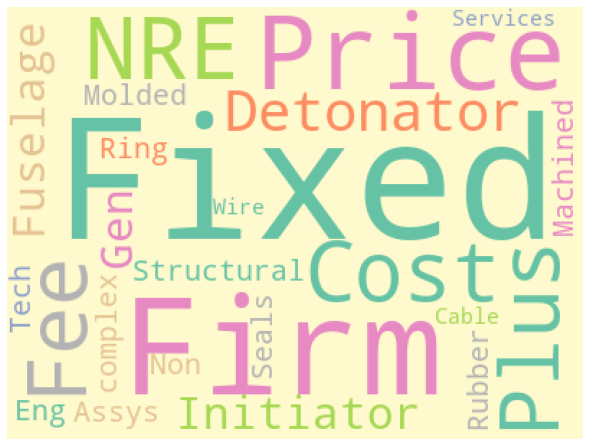

Type 1


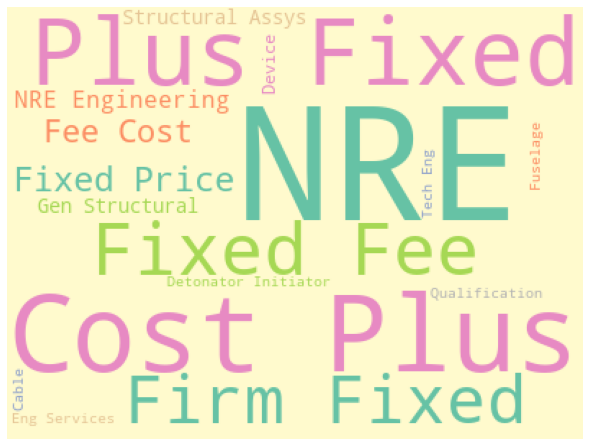

Others


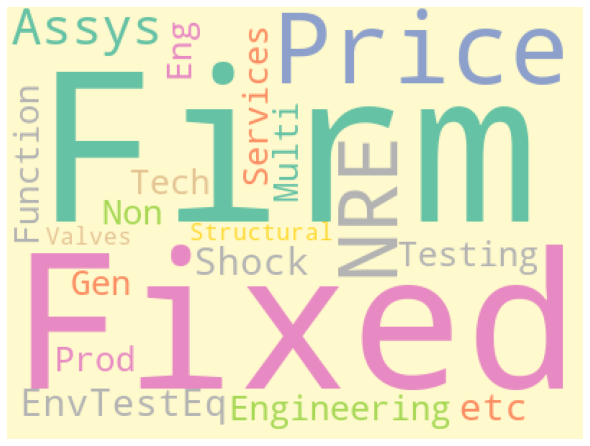

In [124]:
#@title word cloud for each group
stopwords = set(STOPWORDS)
for i in range(3):
  comment_words = ''

  for lb,term in zip(labels,terms):
    '''
    if i == 0, plot lb = 0 case, which is type 2
    if i == 1, plot lb = 1 case, which is type 1
    if i == 2, plot others
    '''
    if (i in {0,1} and lb==i) or (i==2 and lb not in {0,1}):
      comment_words += " ".join(term) + " "

  wordcloud = WordCloud(width = 400, height = 300,
                  background_color ='lemonchiffon',
                  stopwords = stopwords,
                  min_font_size = 10,
                  random_state=1,
                  colormap='Set2').generate(comment_words)
  
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  if i==1: print("Type 1")
  elif i==0: print("Type 2")
  else: print("Others")
  plt.show()

## Map reward type on raw data

In [125]:
vec_names_set = [list(i.keys()) for i in vecs]
vec_names_set

key = [' '.join(i) for i in vec_names_set]
dic = dict(zip(key,labels))

df['subaward_description_group'] = df['subaward_description_simple'].map(dic)

In [126]:
df['subaward_description_group']

0      1
1      1
2      0
3      0
4      0
      ..
343    0
344    1
345    0
346    0
347    0
Name: subaward_description_group, Length: 348, dtype: int64

In [127]:
elements_count = collections.Counter(df['subaward_description_group'])
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

1: 175
0: 160
3: 4
6: 2
5: 2
4: 2
7: 1
2: 2


In [128]:
# regroup to three
subaward_des = {1: 'Type 1', 0: 'Type 2', 2: 'Others',3: 'Others',4: 'Others',
                5: 'Others',6: 'Others',7: 'Others'}
df['subaward_description_group'] = df['subaward_description_group'].map(subaward_des)
df['subaward_description_group']

0      Type 1
1      Type 1
2      Type 2
3      Type 2
4      Type 2
        ...  
343    Type 2
344    Type 1
345    Type 2
346    Type 2
347    Type 2
Name: subaward_description_group, Length: 348, dtype: object

## Regroup subawardee_business_types

only care if the business type if manufacturing of goods, and if it is owned by a veteran

In [129]:
df['manufacture'] = np.where(df['subawardee_business_types'].str.lower().str.contains('goods'), 'Yes', 'No')
df['veteran'] = np.where(df['subawardee_business_types'].str.lower().str.contains('veteran'), 'Yes', 'No')

# Other data cleaning

### Add a column shows project period (subaward_fsrs_report_year - subaward_action_date_fiscal_year)

In [130]:
df['period']=df['subaward_fsrs_report_year']-df['subaward_action_date_fiscal_year']

### Filter useful columns

In [131]:
df_clst = df[['period','subawardee_name','subawardee_duns','manufacture','veteran','subaward_description_group',
              'subaward_description_simple','subaward_primary_place_of_performance_state_code',
              'subaward_action_date','subaward_amount']]

### Check missing values

In [132]:
df_clst.isna().sum()

period                                              0
subawardee_name                                     0
subawardee_duns                                     0
manufacture                                         0
veteran                                             0
subaward_description_group                          0
subaward_description_simple                         0
subaward_primary_place_of_performance_state_code    0
subaward_action_date                                0
subaward_amount                                     0
dtype: int64

### Change data type

In [133]:
df_clst = df_clst.astype({"subaward_description_group": str})
df_clst = df_clst.astype({"period": float})

In [134]:
df_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 10 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   period                                            348 non-null    float64
 1   subawardee_name                                   348 non-null    object 
 2   subawardee_duns                                   348 non-null    int64  
 3   manufacture                                       348 non-null    object 
 4   veteran                                           348 non-null    object 
 5   subaward_description_group                        348 non-null    object 
 6   subaward_description_simple                       348 non-null    object 
 7   subaward_primary_place_of_performance_state_code  348 non-null    object 
 8   subaward_action_date                              348 non-null    object 
 9   subaward_amount      

## k-prototype clustering subaward

https://www.tomasbeuzen.com/post/clustering-mixed-data/
Use the k-prototype algorithm
The k-prototype algorithm can work directly with the categorical data, without the need for encoding. I defer to the k-prototype documentation and the original paper by Huang (1997) for an explanation of how the algorithm works.

In [135]:
df_clst_kprot = df_clst[['period','manufacture','veteran','subaward_description_group','subaward_amount', 
                         'subawardee_duns', 'subawardee_name']]
df_clst_kprot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   period                      348 non-null    float64
 1   manufacture                 348 non-null    object 
 2   veteran                     348 non-null    object 
 3   subaward_description_group  348 non-null    object 
 4   subaward_amount             348 non-null    float64
 5   subawardee_duns             348 non-null    int64  
 6   subawardee_name             348 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 19.2+ KB


In [136]:
# scale the numerical variables
df_clst_kprot_scale = df_clst_kprot.iloc[:,0:5].copy()
numcols = list(df_clst_kprot_scale.dtypes[df_clst_kprot_scale.dtypes == "float64"].index)
print(numcols)
scaler = StandardScaler()
df_clst_kprot_scale[numcols] = scaler.fit_transform(df_clst_kprot_scale[numcols])
df_clst_kprot_scale.rename({'period': 'Project period', 'manufacture': 'Is Manufacturer of Goods?',
                            'veteran':'Is owned by a veteran?','subaward_description_group':'Subaward Type',
                           'subaward_amount':'Subaward Amount'}, axis=1, inplace=True)
df_clst_kprot.rename({'period': 'Project period', 'manufacture': 'Is Manufacturer of Goods?',
                            'veteran':'Is owned by a veteran?','subaward_description_group':'Subaward Description',
                           'subaward_amount':'Subaward Amount'}, axis=1, inplace=True)
df_clst_kprot_scale.info()

['period', 'subaward_amount']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Project period             348 non-null    float64
 1   Is Manufacturer of Goods?  348 non-null    object 
 2   Is owned by a veteran?     348 non-null    object 
 3   Subaward Type              348 non-null    object 
 4   Subaward Amount            348 non-null    float64
dtypes: float64(2), object(3)
memory usage: 13.7+ KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


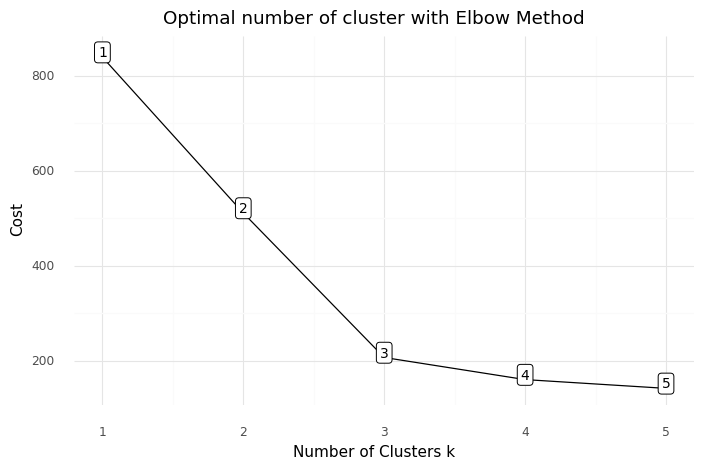

<ggplot: (8745876822337)>

In [137]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 6):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(df_clst_kprot_scale, categorical=[1,2,3])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 10) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [138]:
pred = KPrototypes(n_clusters=3).fit_predict(df_clst_kprot_scale, categorical=[1,2,3])

In [139]:
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,

In [140]:
df_clst_kprot.insert(0, "Cluster", pred)
df_clst_kprot

,Cluster,Project period,Is Manufacturer of Goods?,Is owned by a veteran?,Subaward Description,Subaward Amount,subawardee_duns,subawardee_name
0,2,5.0,Yes,No,Type 1,62696821.0,780680976,ALLIANT TECHSYSTEMS OPERATIONS LLC
1,2,4.0,Yes,No,Type 1,60448995.0,780680976,ALLIANT TECHSYSTEMS OPERATIONS LLC
2,2,2.0,Yes,No,Type 2,60000000.0,780680976,ALLIANT TECHSYSTEMS OPERATIONS LLC
3,2,2.0,Yes,No,Type 2,48800000.0,780680976,ALLIANT TECHSYSTEMS OPERATIONS LLC
4,2,2.0,Yes,No,Type 2,48800000.0,780680976,ALLIANT TECHSYSTEMS OPERATIONS LLC
...,...,...,...,...,...,...,...,...
343,1,0.0,No,No,Type 2,30276.0,18481390,SHELLI INDUSTRIES LLC
344,0,2.0,Yes,No,Type 1,30198.0,788104334,"EAGLEPICHER TECHNOLOGIES, LLC"
345,1,0.0,Yes,No,Type 2,27515.0,131810918,PROMAT INC
346,1,0.0,Yes,No,Type 2,25579.0,39726455,"NICOMATIC, L.P."


### cluster profile plot
https://towardsdatascience.com/one-hot-elbows-and-k-prototypes-more-customer-segmentation-in-python-106d13c55eae

In [141]:
def cluster_profile(df):
    dfc = df.groupby("Cluster").agg({ 
        "Project period": "median",
        "Is Manufacturer of Goods?": lambda x: x.value_counts().index[0],
        "Subaward Amount": "median",
        "Is owned by a veteran?": lambda x: x.value_counts().index[0],
        "Subaward Description": lambda x: x.value_counts().index[0],
                                    })    #.sort_values(by=["MonthlyCharges"], ascending=False)

    cluster_pies(df)
    return dfc

In [142]:
# helper function: pie charts for categorical variables
def cluster_pies(df):
    
    # number of categorical variables
    c = len(df.select_dtypes("object").nunique())
    
    # number of clusters
    K = df["Cluster"].nunique()

    for k in tqdm(range(K)):
        dfc = df[df["Cluster"]==k]
        chrg = dfc["Project period"].median()
        ten = dfc["Subaward Amount"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(20, 12))
        fig.suptitle("Group " + str(k+1) + ": " + \
            f'{cases:,.0f}' + " cases | " + \
            "median period " + f'{chrg:.0f}' + ' years' + \
            " | median subaward amount " + f'{ten:.0f}')

        ## colors for first two plots
        colors_binary = {'Yes':'#66b3ff', 'No':'#ffcc99'}

        ax1 = plt.subplot2grid((2,c),(0,0))
        lbs = dfc["Is Manufacturer of Goods?"].unique()
        plt.pie(dfc["Is Manufacturer of Goods?"].value_counts(), 
                labels=lbs, colors = [colors_binary[lb] for lb in lbs])
        plt.title("Is Manufacturer of Goods?");

        ax1 = plt.subplot2grid((2,c),(0,1))
        lbs = dfc["Is owned by a veteran?"].unique()
        plt.pie(dfc["Is owned by a veteran?"].value_counts(), 
                labels=lbs, colors = [colors_binary[lb] for lb in lbs])
        plt.title("Is owned by a veteran?");

        ## colors for the last plot
        colors_st = {'Type 1': '#66b3ff',
                     'Type 2': '#ffcc99',
                     'Others': '#ff9999'}
        ax1 = plt.subplot2grid((2,c),(0,2))
        lbs = dfc["Subaward Description"].unique()
        plt.pie(dfc["Subaward Description"].value_counts(), 
                labels=lbs, colors = [colors_st[lb] for lb in lbs])
        plt.title("Subaward Description");

100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


Cluster,0,1,2
Project period,2.0,0.0,2.0
Is Manufacturer of Goods?,Yes,Yes,Yes
Subaward Amount,101361.0,126000.0,48800000.0
Is owned by a veteran?,No,No,No
Subaward Description,Type 1,Type 2,Type 2


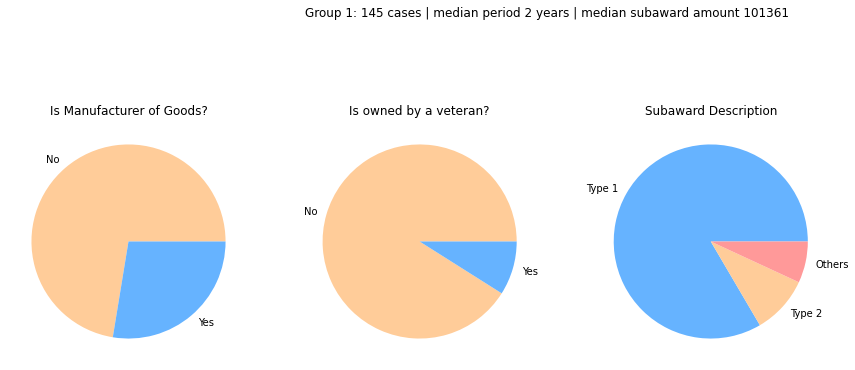

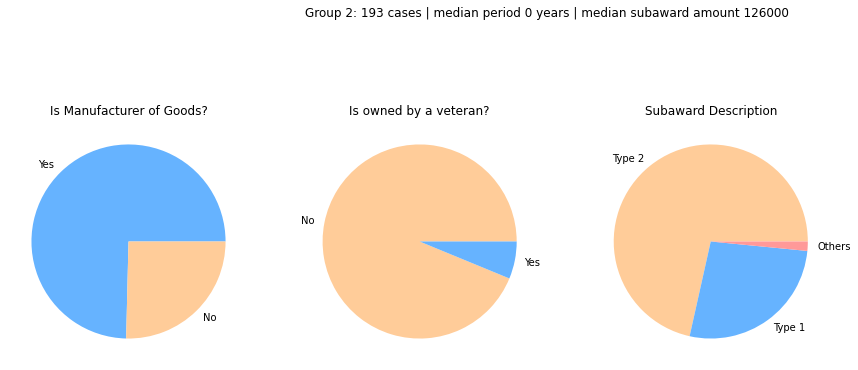

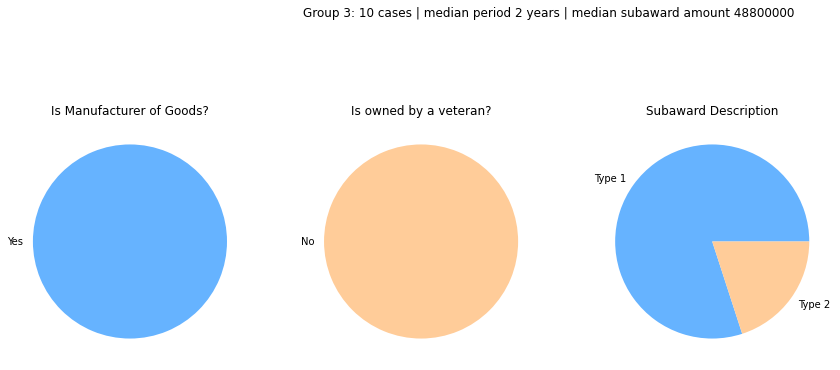

In [143]:
cluster_profile(df_clst_kprot).T

# US Choropleth map

In [144]:
#@title create state level total subaward data
## all state names
pop = vega_data.population_engineers_hurricanes()
all_states = pop[['state', 'id']].\
rename(columns={"state": "State_name"})

## state level summary
state_smy = df.groupby('subawardee_state_name')['subaward_amount'].\
agg({'size','sum','mean','std'})

state_smy.rename(columns = {'size':'Number of awards', 
                            'mean':'Mean of award amounts',
                            'std': 'Std of award amounts'}, 
                 inplace = True)

state_all_info = pd.merge(left = all_states, right = state_smy,
         left_on = "State_name", right_index = True, how = "left").\
         fillna(0)

state_all_info['Log1p subaward amount'] = \
np.log(state_all_info['sum']+1)

## plot choropleth map
states = alt.topo_feature(vega_data.us_10m.url, 'states')

choroleth = alt.Chart(states).mark_geoshape().encode(
    color='Log1p subaward amount:Q',
    tooltip=['State_name:N',
             'Number of awards:Q',
             alt.Tooltip('Mean of award amounts:Q', format='.2~s'),
             alt.Tooltip('Std of award amounts:Q', format='.2~s')]
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_all_info, 'id',
                         list(state_all_info.columns))
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
)
choroleth
#choroleth.save('chart.html')

alt.Chart(...)

In [145]:
temp = df_clst_kprot.groupby(['Cluster', 'subawardee_duns'])['Subaward Amount'].\
sum().sort_values(ascending = False).to_frame()
temp.groupby(level=[0]).head(3).sort_index(level=[0])

Subaward Amount
Cluster subawardee_duns                 
0       39119057               7040982.0
        139119536              3870958.0
        803209782              7924969.0
1       80242612               4965333.0
        780680976             73791179.0
        803209782              9126915.0
2       780680976            479045816.0

In [146]:
# You can use selections to add meaningful interactivity to a chart
# In the example below, selecting a point on the summary chart
# will highlight just that series on the chart on the right

import altair as alt
import pandas as pd
import numpy as np

np.random.seed(0)

n_objects = 20
n_times = 50

# Create one (x, y) pair of metadata per object
locations = pd.DataFrame({
    'id': range(n_objects),
    'x': np.random.randn(n_objects),
    'y': np.random.randn(n_objects)
})

# Create a 50-element time-series for each object
timeseries = pd.DataFrame(np.random.randn(n_times, n_objects).cumsum(0),
                          columns=locations['id'],
                          index=pd.RangeIndex(0, n_times, name='time'))

# Melt the wide-form timeseries into a long-form view
timeseries = timeseries.reset_index().melt('time')

# Merge the (x, y) metadata into the long-form view
timeseries['id'] = timeseries['id'].astype(int)  # make merge not complain
data = pd.merge(timeseries, locations, on='id')

# Data is prepared, now make a chart

# First we create a single selection, which is bound to the 'id' field in the
# data 
selector = alt.selection_single(empty='all', fields=['id'])

# We create a base chart, and add the selector to it
base = alt.Chart(data).properties(
    width=250,
    height=250
).add_selection(selector)

# For the points, we just want the mean of x and y. We set the color to
# be determined by the selector
points = base.mark_point(filled=True, size=200).encode(
    x='mean(x)',
    y='mean(y)',
    color=alt.condition(selector, 'id:O', alt.value('lightgray'), legend=None),
)

# For the time series we want the full vales, and here we add a filter that
# depends on the selector
timeseries = base.mark_line().encode(
    x='time',
    y=alt.Y('value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
)

# Combining the two charts, the selection on the left now controls what's
# displayed on the right
points | timeseries

alt.HConcatChart(...)